In [5]:
import json
import matplotlib.pyplot as plt

In [21]:
name = "arcee-aitrinity-large-preview:free";
labels = ["CPG", "CPG_TRUE", "PDG", "TEXTGRAPH_PDG", ""]

with open(f"./results/timings/timings_textgraph_arcee-ai_trinity-large-preview_free.json", "r", encoding="utf-8") as f:
    read_file = json.load(f)
maxmili = max(map(lambda x: int(x["ms"]), read_file))
print(maxmili/1000/60)

61.50423333333333


CPG: acc=0.67  f1=0.72  prec=0.65  rec=0.81
CPG_TRUE: acc=0.66  f1=0.71  prec=0.64  rec=0.80
PDG: acc=0.63  f1=0.70  prec=0.60  rec=0.83
TEXTGRAPH_PDG: acc=0.68  f1=0.73  prec=0.62  rec=0.90
NOGRAPH: acc=0.59  f1=0.70  prec=0.55  rec=0.98


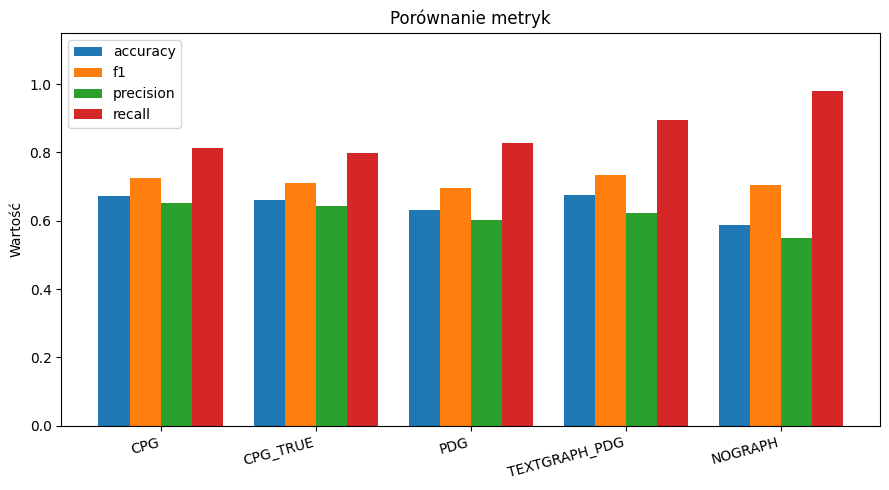

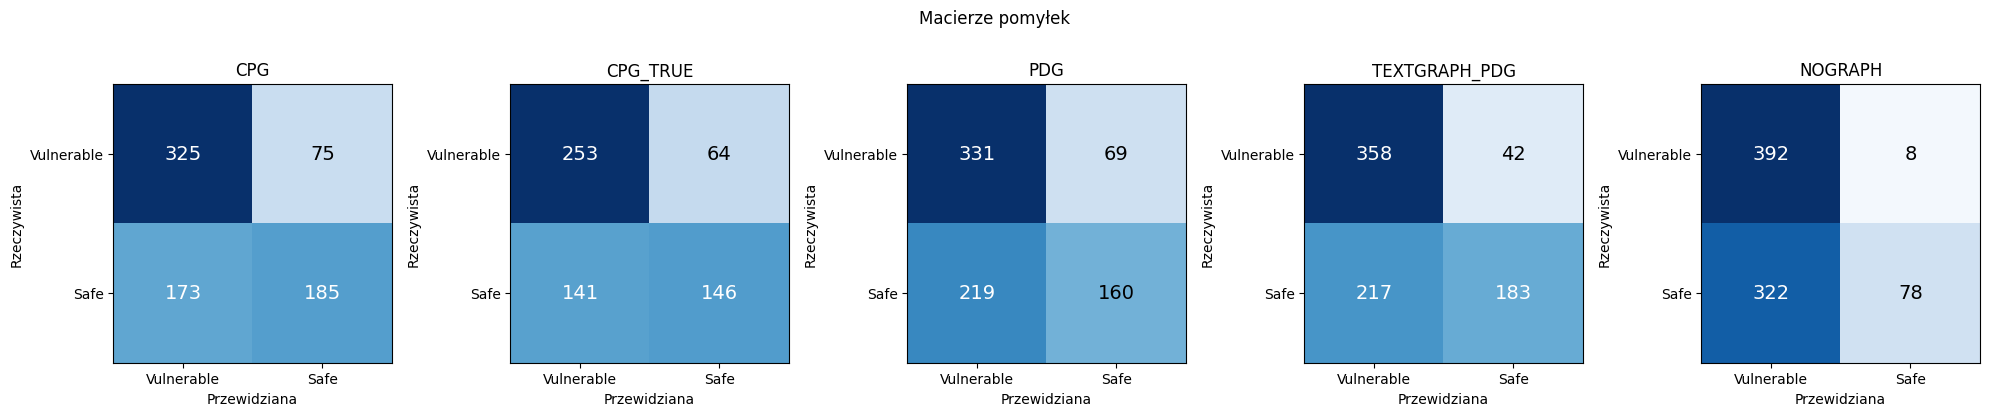

In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
)

# --- KONFIGURACJA ---
name = "arcee-aitrinity-large-preview:free";
labels = ["CPG", "CPG_TRUE", "PDG", "TEXTGRAPH_PDG", ""]
FILES = {
    (lab if lab else "NOGRAPH"): (f"results/{name}-{lab}.json" if lab else f"results/{name}.json")
    for lab in labels
}

# --- WCZYTYWANIE ---
def wczytaj_plik(sciezka):
    with open(sciezka) as f:
        return json.load(f)

# --- METRYKI ---
def licz_metryki(dane):
    expected = [1 if d["expected"] == "Vulnerable" else 0 for d in dane]
    received = [1 if d["received"] == "Vulnerable" else 0 for d in dane]
    return {
        "accuracy":  accuracy_score(expected, received),
        "f1":        f1_score(expected, received, zero_division=0),
        "precision": precision_score(expected, received, zero_division=0),
        "recall":    recall_score(expected, received, zero_division=0),
        "cm":        confusion_matrix(expected, received, labels=[1, 0]),
    }

# --- WCZYTAJ WSZYSTKO ---
wyniki = {}
for nazwa, sciezka in FILES.items():
    wyniki[nazwa] = licz_metryki(wczytaj_plik(sciezka))
    m = wyniki[nazwa]
    print(f"{nazwa}: acc={m['accuracy']:.2f}  f1={m['f1']:.2f}  "
          f"prec={m['precision']:.2f}  rec={m['recall']:.2f}")

# --- WYKRES 1: Porównanie metryk (bar chart) ---
metryki = ["accuracy", "f1", "precision", "recall"]
nazwy = list(wyniki.keys())
x = np.arange(len(nazwy))
szerokosc = 0.2

fig, ax = plt.subplots(figsize=(9, 5))
for i, metryka in enumerate(metryki):
    wartosci = [wyniki[n][metryka] for n in nazwy]
    ax.bar(x + i * szerokosc, wartosci, szerokosc, label=metryka)

ax.set_xticks(x + szerokosc * 1.5)
ax.set_xticklabels(nazwy, rotation=15, ha="right")
ax.set_ylim(0, 1.15)
ax.set_ylabel("Wartość")
ax.set_title("Porównanie metryk")
ax.legend()
plt.tight_layout()
plt.savefig("metryki.png", dpi=150)
plt.show()

# --- WYKRES 2: Macierze pomyłek ---
n = len(wyniki)
fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
if n == 1:
    axes = [axes]

etykiety = ["Vulnerable", "Safe"]

for ax, (nazwa, m) in zip(axes, wyniki.items()):
    cm = m["cm"]
    ax.imshow(cm, cmap="Blues", vmin=0)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(etykiety)
    ax.set_yticklabels(etykiety)
    ax.set_xlabel("Przewidziana")
    ax.set_ylabel("Rzeczywista")
    ax.set_title(nazwa)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=14,
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.suptitle("Macierze pomyłek", y=1.02)
plt.tight_layout()
plt.savefig("confusion_matrices.png", dpi=150)
plt.show()

Próbek: 789
Po odcięciu outlierów: 702 próbek


/tmp/ipykernel_73488/528040514.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


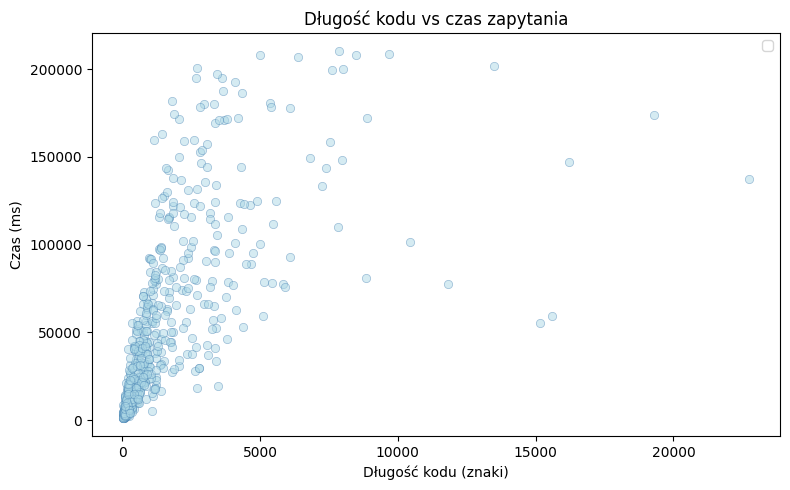

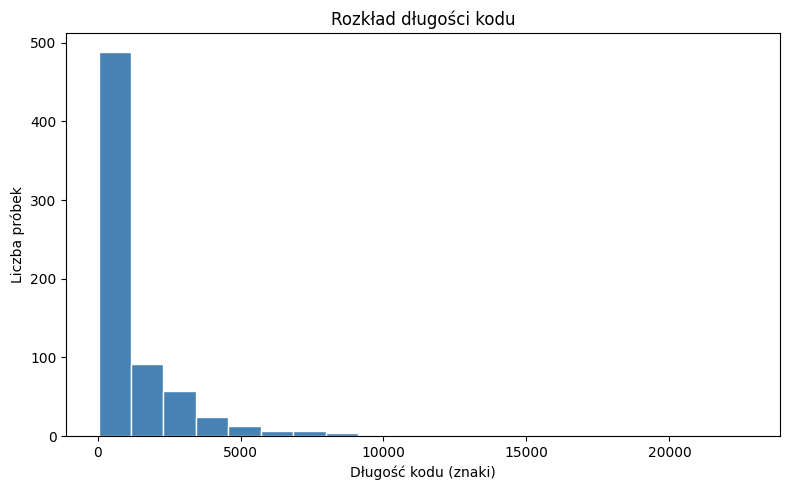

/tmp/ipykernel_73488/528040514.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grupy, labels=etykiety, patch_artist=True,


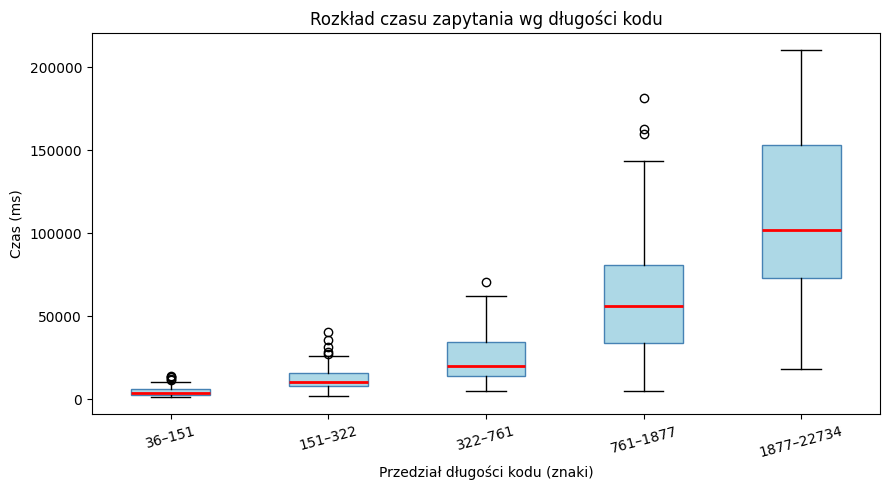

In [12]:
import sqlite3
import json
import matplotlib.pyplot as plt
import numpy as np

# --- KONFIGURACJA ---
DB_PATH = "./formatted_data/data_test.sqlite"
TIMINGS_FILE = "./results/timings/timings_textgraph_arcee-ai_trinity-large-preview_free.json"

# --- WCZYTAJ TIMINGS ---
with open(TIMINGS_FILE) as f:
    timings_raw = json.load(f)

timings = {entry["id"]: entry["ms"] for entry in timings_raw}

# --- WCZYTAJ DŁUGOŚCI KODU Z SQLITE ---
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()
placeholders = ",".join("?" * len(timings))
cur.execute(f"SELECT id, code FROM data WHERE id IN ({placeholders})", list(timings.keys()))
rows = cur.fetchall()
conn.close()

code_lengths = {row[0]: len(row[1]) for row in rows}

# --- POŁĄCZ DANE ---
ids     = sorted(set(timings) & set(code_lengths))
lengths = np.array([code_lengths[i] for i in ids])
times   = np.array([timings[i]      for i in ids])

print(f"Próbek: {len(ids)}")

def usun_outliery(lengths, times, k=1.5):
    q1, q3 = np.percentile(times, [25, 75])
    iqr = q3 - q1
    maska = (times >= q1 - k * iqr) & (times <= q3 + k * iqr)
    return lengths[maska], times[maska]

lengths, times = usun_outliery(lengths, times)
print(f"Po odcięciu outlierów: {len(times)} próbek")

# --- WYKRES 1: Scatter — długość kodu vs czas ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(lengths, times, alpha=0.5, edgecolors="steelblue", facecolors="lightblue", linewidths=0.5)
#z = np.polyfit(lengths, times, 1)
xs = np.linspace(lengths.min(), lengths.max(), 200)
#ax.plot(xs, np.poly1d(z)(xs), "r--", linewidth=1.5, label="trend")
ax.set_xlabel("Długość kodu (znaki)")
ax.set_ylabel("Czas (ms)")
ax.set_title("Długość kodu vs czas zapytania")
ax.legend()
plt.tight_layout()
plt.show()

# --- WYKRES 2: Histogram długości kodu ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(lengths, bins=20, color="steelblue", edgecolor="white")
ax.set_xlabel("Długość kodu (znaki)")
ax.set_ylabel("Liczba próbek")
ax.set_title("Rozkład długości kodu")
plt.tight_layout()
plt.show()

# --- WYKRES 3: Box plot czasu wg przedziału długości ---
n_bins = 5
bins = np.unique(np.percentile(lengths, np.linspace(0, 100, n_bins + 1)))
grupy, etykiety = [], []
for i in range(len(bins) - 1):
    maska = (lengths >= bins[i]) & (lengths < bins[i + 1])
    if maska.sum() > 0:
        grupy.append(times[maska])
        etykiety.append(f"{int(bins[i])}–{int(bins[i+1])}")

fig, ax = plt.subplots(figsize=(9, 5))
ax.boxplot(grupy, labels=etykiety, patch_artist=True,
           boxprops=dict(facecolor="lightblue", color="steelblue"),
           medianprops=dict(color="red", linewidth=2))
ax.set_xlabel("Przedział długości kodu (znaki)")
ax.set_ylabel("Czas (ms)")
ax.set_title("Rozkład czasu zapytania wg długości kodu")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()